In [1]:
from af import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
errors = []
losses = []
for m in range(-3, 4, 2):
    for c in range(4):
        training_data = SampleIterator(m, c, 64,1)
        eval_data = SampleIterator(m,c,noise_factor = 1)
        error, loss = train_and_test(training_data, eval_data, 3,torch.nn.MSELoss(), 32,lr = 0.005)
        errors.append(error)
        losses.append(loss)
errors = np.mean(np.array(errors), axis =0)
losses = np.mean(np.array(losses), axis =0)
losses/=np.max(losses)

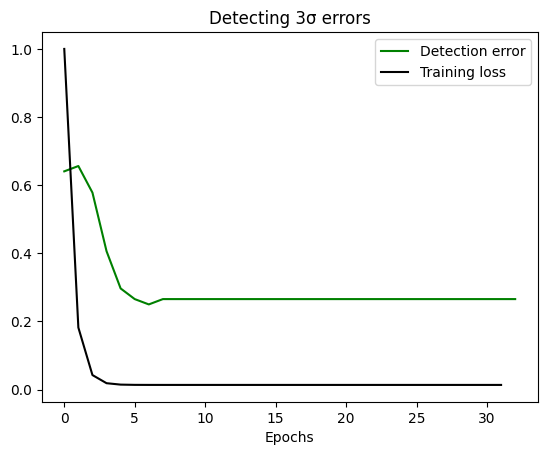

In [3]:
fig, ax = plt.subplots()
ax.plot(errors, color = 'green',label = 'Detection error')
ax.plot(losses, color = 'black', label = 'Training loss')
ax.set_xlabel('Epochs')
ax.set_title('Detecting 3σ errors')
ax.legend()

In [4]:
errors = []
losses = []
for m in range(-3, 4, 2):
    for c in range(4):
        training_data = SampleIterator(m, c, 64,1)
        eval_data = SampleIterator(m,c,noise_factor = 1)
        error, loss = (training_data, eval_data, 4,torch.nn.MSELoss(), 32,lr = 0.005)
        errors.append(error)
        losses.append(loss)
errors = np.mean(np.array(errors), axis =0)
losses = np.mean(np.array(losses), axis =0)
losses/=np.max(losses)

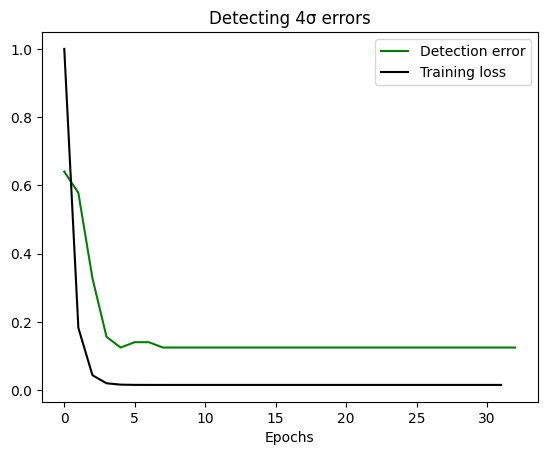

In [5]:
fig, ax = plt.subplots()
ax.plot(errors, color = 'green',label = 'Detection error')
ax.plot(losses, color = 'black', label = 'Training loss')
ax.set_xlabel('Epochs')
ax.set_title('Detecting 4σ errors')
ax.legend()

In [6]:
def custom_sampler(x, y):
    si = SampleIterator()
    si.x, si.y, si.l = x, y, len(x)
    return si
lr = 0.005
init_period = 32
base, filt = [], []
loss = torch.nn.MSELoss()
for m in range(-3, 4, 2):
    for c in range(4):
        base_epoch = []
        filt_epoch = []
        base_model = ExampleLRModel()
        filt_model = ExampleLRModel()
        base_opt = torch.optim.SGD(base_model.parameters(), lr = lr)
        filt_opt = torch.optim.SGD(filt_model.parameters(), lr = lr)
        training_data = SampleIterator(m,c,64, noise_factor = 1)
        eval_data = SampleIterator(m,c,16,noise_factor = 1)
        for epoch in range(128):
            epoch_base, epoch_filt = [], []
            x, y = [], []
            for i in range(8):
                index = i*8 + epoch%8
                xi, yi = training_data[index]
                x.append(xi)
                y.append(yi if (i!=4 or epoch<init_period) else yi+3)
                base_opt.zero_grad()
                (loss(base_model(xi), y[-1])).backward()
                base_opt.step()
            af = AF(filt_model, custom_sampler(x,y), loss, 0)
            for i in range(8):
                if af.grads[i].rank<2 or epoch<init_period:
                    xi, yi = x[i], y[i]
                    filt_opt.zero_grad()
                    loss(filt_model(xi), yi).backward()
                    filt_opt.step()
            for x, y in eval_data:
                epoch_base.append(loss(base_model(x), y).item())
                epoch_filt.append(loss(filt_model(x), y).item())
            base_epoch.append(np.mean(epoch_base))
            filt_epoch.append(np.mean(epoch_filt))
        del base_model
        del filt_model
        base.append(base_epoch)
        filt.append(filt_epoch)
base = np.mean(np.array(base), axis =0)
filt = np.mean(np.array(filt), axis =0)

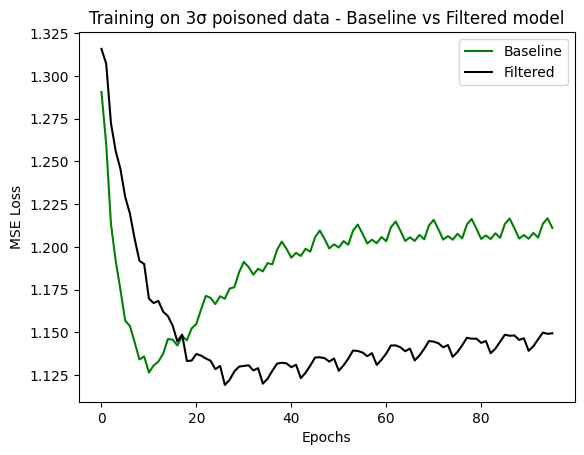

In [7]:
fig, ax = plt.subplots()
ax.plot(base[init_period:], color = 'green',label = 'Baseline')
ax.plot(filt[init_period:], color = 'black', label = 'Filtered')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE Loss')
ax.set_title('Training on 3σ poisoned data - Baseline vs Filtered model')
ax.legend()
plt.show()